In [1]:
import os
import re
import collections
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if os.getcwd().endswith('notebook'):
    os.chdir('..')

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

## Assemblies

In [3]:
assemblies_path = os.path.join(os.getcwd(), 'data/assemblies.csv')
assembly_df = pd.read_csv(assemblies_path, index_col='assembly_accession')
assemblies = np.array(assembly_df.index.tolist())
assembly_df.head()

,taxid,species_taxid,organism_name,domain,phylum,class,order,family,genus,species,strain,assembly_level
assembly_accession,,,,,,,,,,,,
GCA_000010525.1,438753,7,Azorhizobium caulinodans ORS 571,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans,Azorhizobium caulinodans ORS 571,Complete Genome
GCA_000218545.1,593907,11,Cellulomonas gilvus ATCC 13127,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Cellulomonadaceae,Cellulomonas,Cellulomonas gilvus,Cellulomonas gilvus ATCC 13127,Complete Genome
GCA_000020965.1,309799,14,Dictyoglomus thermophilum H-6-12,Bacteria,Dictyoglomi,Dictyoglomia,Dictyoglomales,Dictyoglomaceae,Dictyoglomus,Dictyoglomus thermophilum,Dictyoglomus thermophilum H-6-12,Complete Genome
GCA_000012885.1,338963,19,Pelobacter carbinolicus DSM 2380,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfuromonadales,Desulfuromonadaceae,Pelobacter,Pelobacter carbinolicus,Pelobacter carbinolicus DSM 2380,Complete Genome
GCA_001735525.1,23,23,Shewanella colwelliana,Bacteria,Proteobacteria,Gammaproteobacteria,Alteromonadales,Shewanellaceae,Shewanella,NaN,Shewanella colwelliana,Scaffold


In [15]:
len(assembly_df[assembly_df['domain'] == 'Archaea'])

1419

## Sample accession and plot

In [5]:
def sample_assemblies(assemblies, n_samples, seed=None):
    rs = np.random.RandomState(seed)
    return rs.choice(assemblies, replace=False, size=n_samples)

In [6]:
def plot_domain_distances(
    assembly_df, 
    domain_query, 
    query_type,
    n_samples, 
    tail='left',
    phylum=None,
    n_cols=3, 
    seed=None,
):
    n_rows = int(np.ceil(n_samples / n_cols))
    
    _, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    axes = axes.flatten()
    n_axes = len(axes)
    
    if phylum is not None:
        assemblies = assembly_df[assembly_df['phylum'] == phylum].index
    else:
        assemblies = assembly_df.index
    
    sampled_assemblies = sample_assemblies(assemblies, n_samples, seed)
    
    for i, assembly in enumerate(sampled_assemblies):
        ax = axes[i]
        if (i+1) > n_axes:
            ax.remove()
            continue
            
        gene_dist_path = os.path.join(
            os.getcwd(),
            f'data/sequences/{assembly}/{assembly}_tri_nucleotide_distance_to_mean.csv',
        )
        gene_dist = pd.read_csv(gene_dist_path)
            
        if query_type == 'pfam':
            source_path = os.path.join(
                os.getcwd(),
                f'data/sequences/{assembly}/{assembly}_pfam.csv.gz',
            )
        else:
            source_path = os.path.join(
                os.getcwd(),
                f'data/sequences/{assembly}/{assembly}_tigr.csv.gz',
            )
            
        domain_source = pd.read_csv(source_path)
        
        protein_ids = domain_source[domain_source['query'] == domain_query]['protein_id'].values

        distances = gene_dist['distance'].values
        ax.hist(distances, bins=100, alpha=0.5);

        mean = np.mean(distances)
        ax.axvline(mean, color='black', alpha=0.7)

        for v in gene_dist[gene_dist['protein_id'].isin(protein_ids)]['distance'].values:
            if tail == 'left':
                color = 'green' if v < mean else 'red'
            else:
                color = 'green' if v > mean else 'red'
                
            ax.axvline(v, color=color, alpha=0.7);
            
        ax.set_title(assembly)
        
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

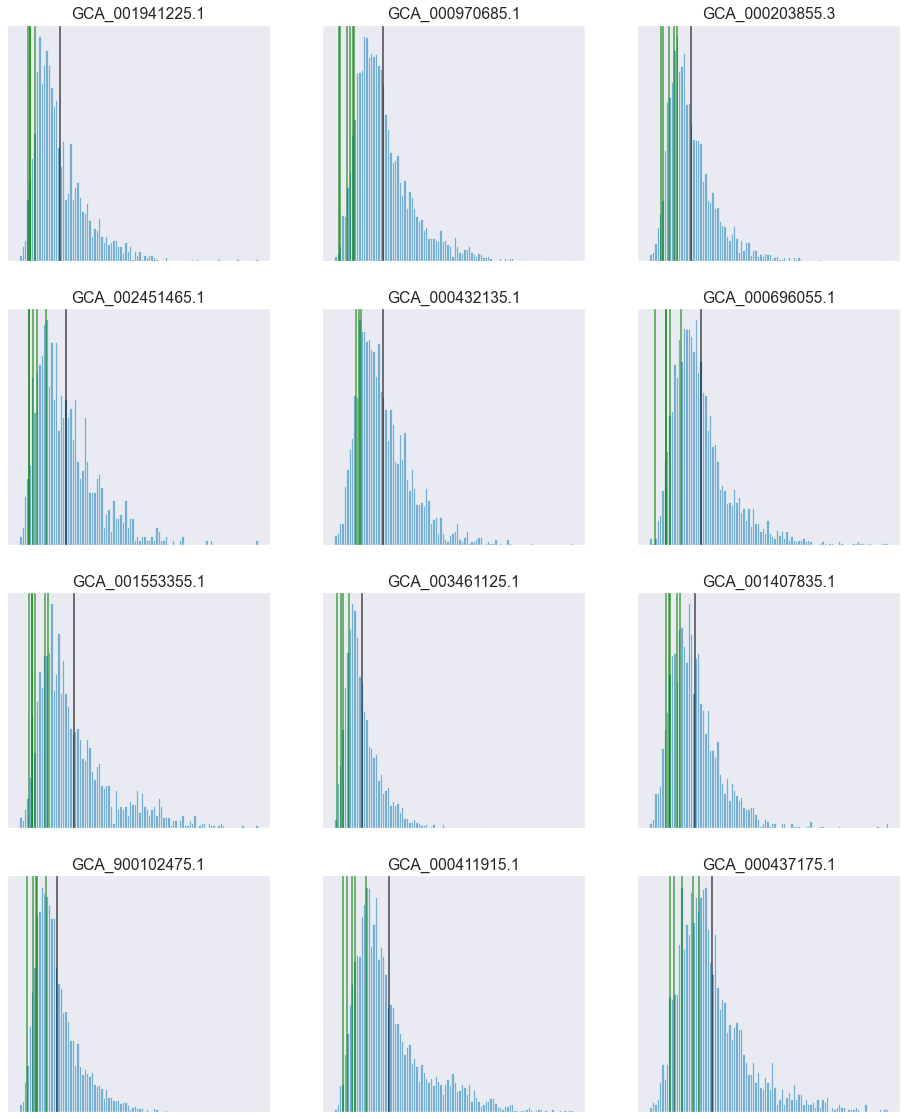

In [7]:
plot_domain_distances(
    assembly_df, 
    domain_query='tRNA-synt_1g', 
    query_type='pfam', 
    n_samples=12, 
    phylum='Firmicutes',
    seed=444,
)

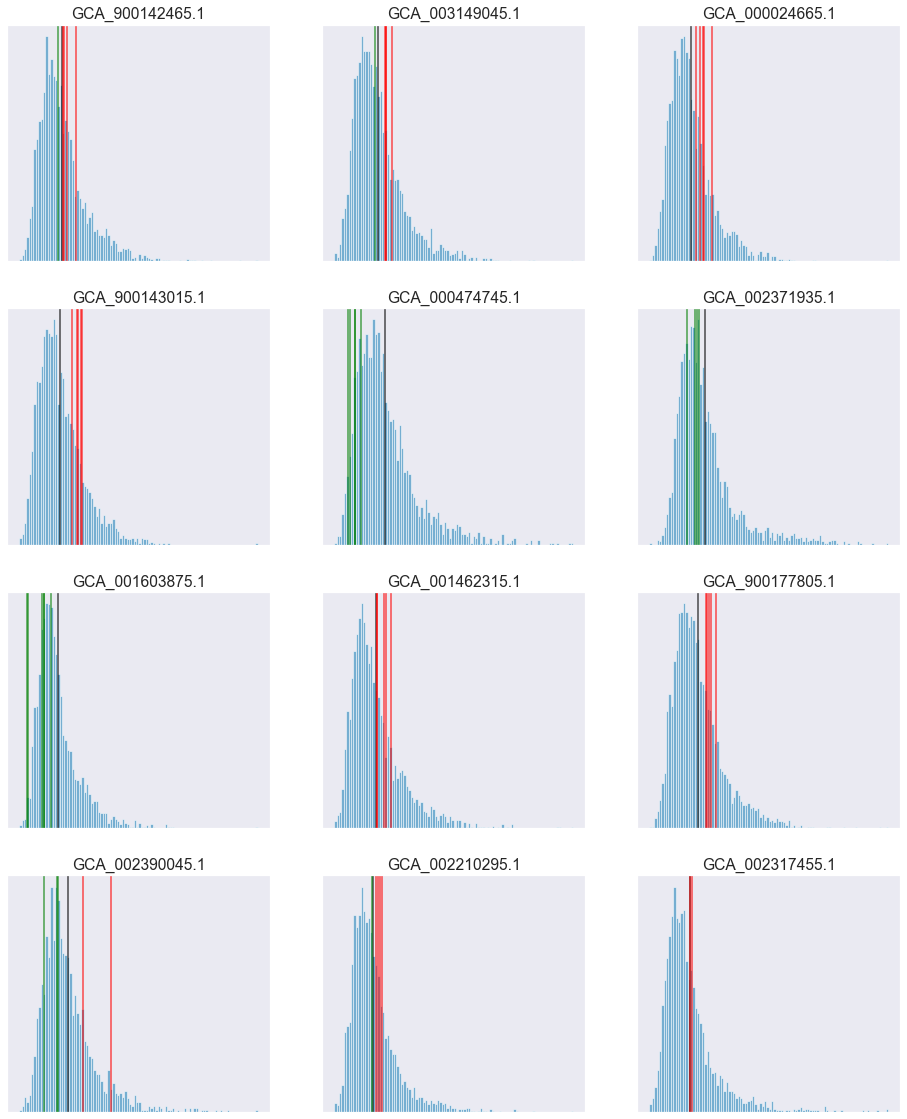

In [8]:
plot_domain_distances(
    assembly_df, 
    domain_query='tRNA-synt_1g', 
    query_type='pfam', 
    n_samples=12, 
    phylum='Fibrobacteres',
    seed=444,
)

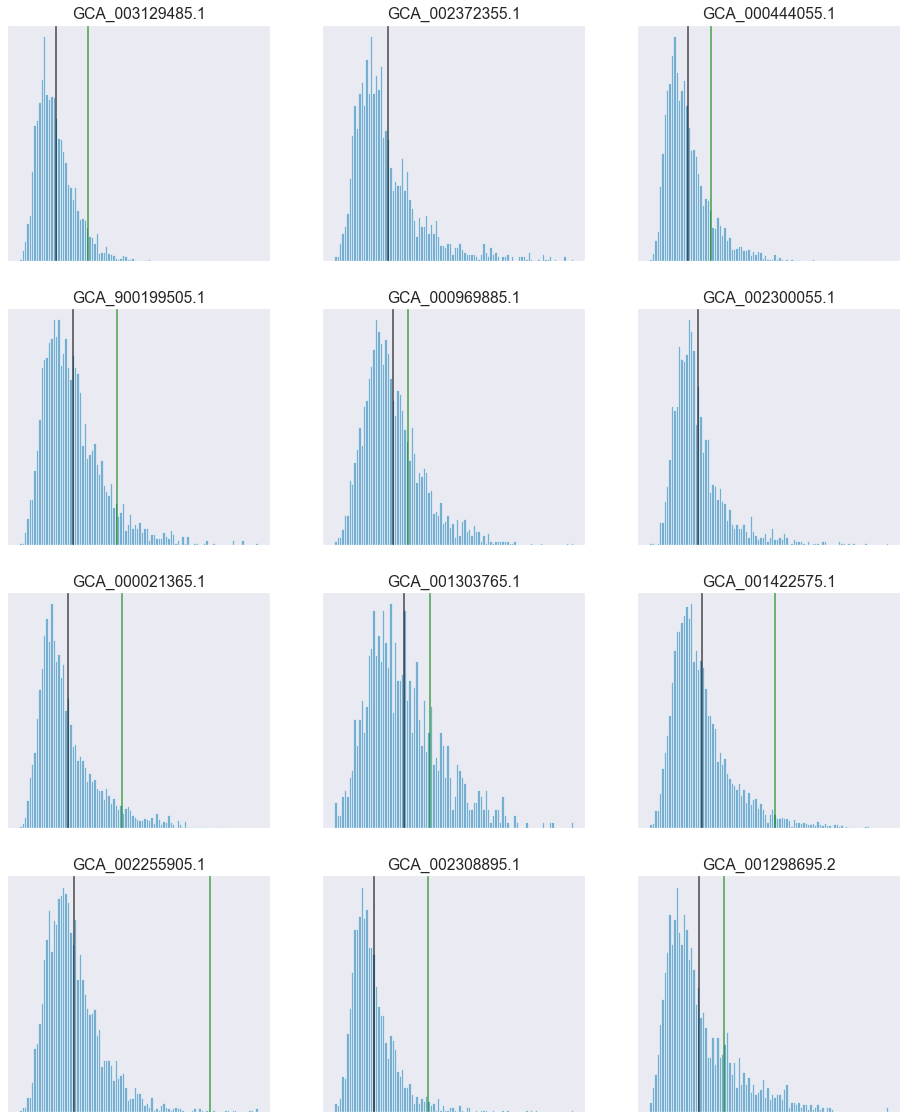

In [9]:
plot_domain_distances(
    assembly_df, 
    domain_query='Ribosomal_S17', 
    query_type='pfam', 
    tail='right',
    n_samples=12, 
    seed=100,
)

## Evidence count

In [10]:
def compute_evidence_count(assembly_df, query, query_type):
    counts = collections.defaultdict(int)
    phyla = assembly_df['phylum'].unique()
    for i, phylum in enumerate(phyla):
        if pd.isnull(phylum):
            continue
            
        phylum_p = phylum.lower().replace(' ', '_')
            
        path = os.path.join(
            os.getcwd(),
            f'data/phylum/{phylum_p}/{phylum_p}_{query_type}_probability_left.csv',
        )
        if not os.path.isfile(path):
            continue
            
        df = pd.read_csv(path, index_col='query')
        try:
            evidence = df.loc[query]['evidence_strength']
            counts[evidence] += 1
        except KeyError:
            continue
            
    return dict(counts)

In [11]:
compute_evidence_count(assembly_df, 'tRNA-synt_1g', 'pfam')

{'Decisive': 40, 'Substantial': 3, 'Very Strong': 13, 'Strong': 12}

In [12]:
compute_evidence_count(assembly_df, 'tRNA-synt_1', 'pfam')

{'Decisive': 36, 'Weak': 1, 'Strong': 14, 'Very Strong': 10, 'Substantial': 7}

In [13]:
compute_evidence_count(assembly_df, 'Helicase_C', 'pfam')

{'Decisive': 51, 'Substantial': 3, 'Weak': 1, 'Strong': 7, 'Very Strong': 6}